In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim as optim

orig_set = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/APS360/Lab 3/Lab_3b_Gesture_Dataset", transforms.ToTensor());

# Rough split ratio: training - 70%, validation - 15%, test - 15%
n = len(orig_set)
n_train = int(0.7 *n)
n_valid = int(0.15 *n)
n_test = n - n_train - n_valid

[train_set, valid_set, test_set] = torch.utils.data.random_split(orig_set, [n_train, n_valid, n_test])


###CNN Model

#### Architecture

In [ ]:
class GestureClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)             # 5x5 kernel, 5 output channels
        self.pool = nn.MaxPool2d(2, 2)              # 2x2 pooling filter, size 2 stride
        self.conv2 = nn.Conv2d(5, 10, 5)            # 5x5 kernel, 10 output channels
        self.fc1 = nn.Linear(28090, 224)
        self.fc2 = nn.Linear(224, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 28090)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Helper Functions

In [ ]:
# Evaluates the accuracy (and loss) given a model and data loader

def evaluate(model, loader, criterion = None):
    total_losses = 0
    total_correct = 0
    total_examples = 0

    for i, [inputs, labels] in enumerate(loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        
        # Track total loss
        if criterion:
            loss = criterion(outputs, labels)
            total_losses += loss.item()

        # Track total correct
        pred = outputs.argmax(dim = 1)
        total_correct += pred.eq(labels).sum().item()
        total_examples += inputs.shape[0]

    if criterion:
        return total_losses/(i+1), total_correct/total_examples     # If loss function is passed in, return both loss and accuracy
    else:
        return total_correct/total_examples                         # Otherwise, only return accuracy


In [ ]:
# Train model

def train(model, train_data, valid_data, learning_rate = 0.001, batch_size = 64, num_epochs = 10):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = True, num_workers = 2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)      # Adam optimizer

    iters, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []


    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)                     # forward pass

            loss = criterion(outputs, labels)           # calculate loss
            loss.backward()                             # calculate gradients using backprop
            optimizer.step()                            # apply optimizer step
            optimizer.zero_grad()                       # zero the gradients

        # Calculate and record loss/accuracy values
        [l, a] = evaluate(model, train_loader, criterion)
        train_losses.append(l)
        train_acc.append(a)

        [l, a] = evaluate(model, valid_loader, criterion)
        valid_losses.append(l)
        valid_acc.append(a)

        iters.append(epoch)

    # Plot training curves
    plt.title("Training Curve - Loss")
    plt.plot(iters, train_losses, label = "Training")
    plt.plot(iters, valid_losses, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(valid_losses[-1]))
    print()

    plt.title("Training Curve - Accuracy")
    plt.plot(iters, train_acc, label = "Training")
    plt.plot(iters, valid_acc, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))


#### Overfitting Test

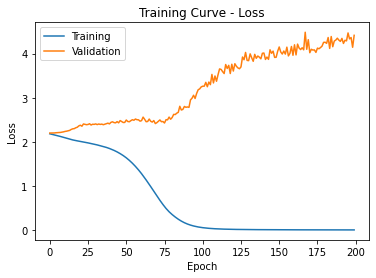

Final Training Loss: 0.002628589980304241
Final Validation Loss: 4.413781762123108



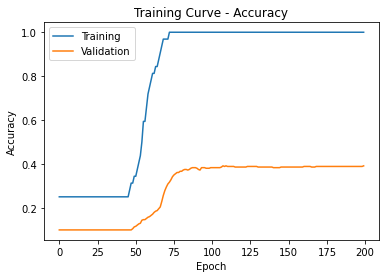

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.39118457300275483


In [ ]:
debug_data = torch.utils.data.Subset(train_set, range(0, 32))       # Pick 32 examples from train_set (set batch size as 32 as well)
model = GestureClassifier()

if torch.cuda.is_available():
    model.cuda()

train(model, debug_data, valid_set, learning_rate=0.0001, batch_size = 32, num_epochs = 200)

#### Model Optimization



#####Version 1:
*   Learning rate = 0.001
*   Batch size = 64
*   Number of epochs = 10






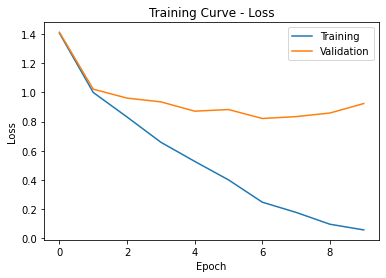

Final Training Loss: 0.055584495473239154
Final Validation Loss: 0.923870176076889



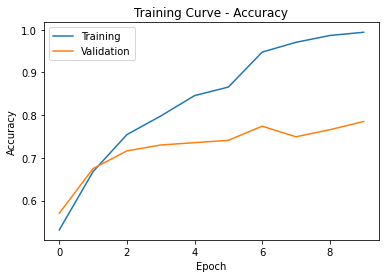

Final Training Accuracy: 0.9941107184923439
Final Validation Accuracy: 0.7851239669421488


In [ ]:
model1 = GestureClassifier()

if torch.cuda.is_available():
    model1.cuda()

train(model1, train_set, valid_set, learning_rate=0.001, batch_size = 64, num_epochs = 10)



#####Version 2:
*   Increased number of epochs from 10 to 20







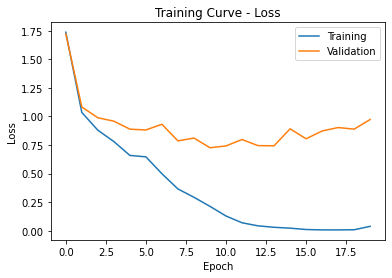

Final Training Loss: 0.03798177853847543
Final Validation Loss: 0.9737232625484467



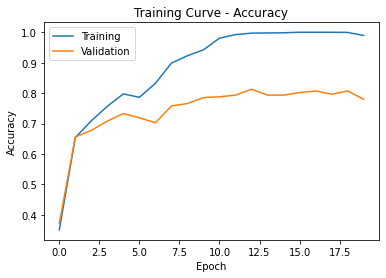

Final Training Accuracy: 0.9893992932862191
Final Validation Accuracy: 0.7796143250688705


In [ ]:
model2 = GestureClassifier()

if torch.cuda.is_available():
    model2.cuda()

train(model2, train_set, valid_set, learning_rate=0.001, batch_size = 64, num_epochs = 20)



#####Version 3:
*   Decreased learning rate from 0.001 to 0.0001
*   Increased number of epochs from 20 to 40





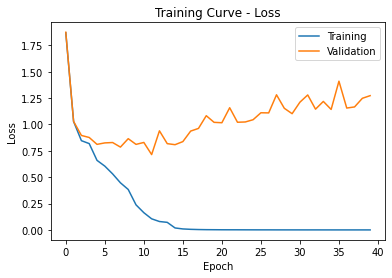

Final Training Loss: 0.00023865794651943293
Final Validation Loss: 1.272933562596639



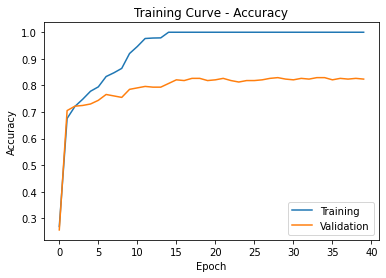

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8236914600550964


In [ ]:
model3 = GestureClassifier()

if torch.cuda.is_available():
    model3.cuda()

train(model3, train_set, valid_set, learning_rate=0.001, batch_size = 32, num_epochs = 40)


##### Version 4:
*   Reverted learning rate from 0.0001 back to 0.001
*   Decreased number of epochs from 40 to 30
*   Reduced batch size from 64 to 32



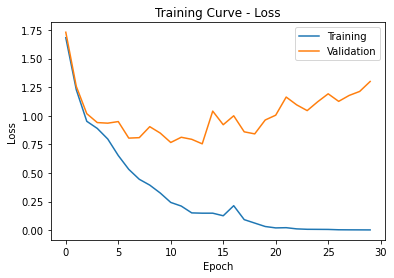

Final Training Loss: 0.002130353747849801
Final Validation Loss: 1.299906849861145



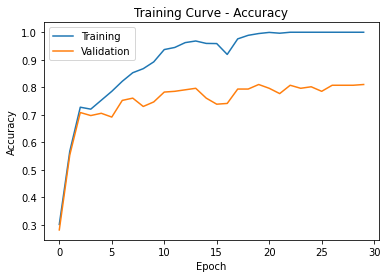

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8099173553719008


In [ ]:
model4 = GestureClassifier()

if torch.cuda.is_available():
    model4.cuda()

train(model4, train_set, valid_set, learning_rate=0.001, batch_size = 32, num_epochs = 30)


#####Version 5:
*   Increased the output channels of conv1 from 5 to 10
*   Increased the output channels of conv1 from 10 to 25
*   Added conv3 with output channels of 50 (no pooling)


In [ ]:
class GestureClassifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)            # 5 -> 10 output channels
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(10, 25, 5)           # 10 -> 25 output channels
        self.conv3 = nn.Conv2d(25, 50, 5)           # Added layer with 50 output channels
        self.fc1 = nn.Linear(120050, 224)
        self.fc2 = nn.Linear(224, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 120050)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

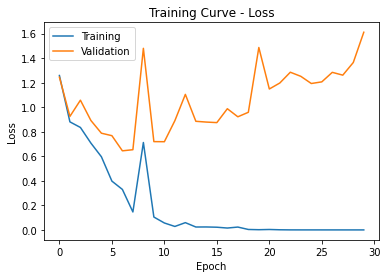

Final Training Loss: 0.00011592627352338577
Final Validation Loss: 1.610918367902438



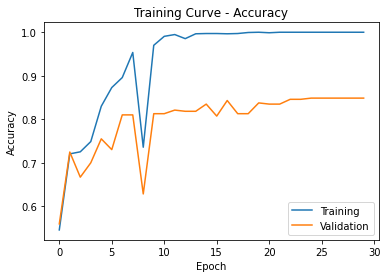

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8484848484848485


In [ ]:
model5 = GestureClassifier2()

if torch.cuda.is_available():
    model5.cuda()

train(model5, train_set, valid_set, learning_rate=0.001, batch_size = 32, num_epochs = 30)

#####Test Accuracy

In [ ]:
# Calculating test accuracy for version 5 since it's the best one so far

test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, num_workers = 2)
accuracy = evaluate(model5, test_loader)

print(accuracy)

0.8438356164383561


### Transfer Learning via AlexNet

In [ ]:
import torchvision.models
alexNet = torchvision.models.alexnet(pretrained=True)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


#### Saving AlexNet features

In [ ]:
import os
import shutil


classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
root_folder = "/content/drive/MyDrive/Colab Notebooks/APS360/Lab 3/saved_features"


shutil.rmtree(root_folder, ignore_errors = True)                    # Deletes existing folder if it exists


## Apply AlexNet features over every training example, and save the resulting tensor in .pt files

# Training set
for i, [input, label] in enumerate(train_set):
    feature = alexNet.features(input.unsqueeze(0))
    feature = torch.from_numpy(feature.detach().numpy())

    save_folder = "{}/training/{}".format(root_folder, classes[label])

    if not os.path.exists(save_folder):                             # Creates folder path
        os.makedirs(save_folder)

    torch.save(feature, "{}/{}.pt".format(save_folder, i))

# Validation set
for i, [input, label] in enumerate(valid_set):
    feature = alexNet.features(input.unsqueeze(0))
    feature = torch.from_numpy(feature.detach().numpy())

    save_folder = "{}/validation/{}".format(root_folder, classes[label])

    if not os.path.exists(save_folder):                             # Creates folder path
        os.makedirs(save_folder)

    torch.save(feature, "{}/{}.pt".format(save_folder, i))

# Test set
for i, [input, label] in enumerate(test_set):
    feature = alexNet.features(input.unsqueeze(0))
    feature = torch.from_numpy(feature.detach().numpy())

    save_folder = "{}/test/{}".format(root_folder, classes[label])

    if not os.path.exists(save_folder):                             # Creates folder path
        os.makedirs(save_folder)

    torch.save(feature, "{}/{}.pt".format(save_folder, i))


#### Architecture

In [ ]:
class GestureClassifierAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 224)
        self.fc2 = nn.Linear(224, 9)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Training

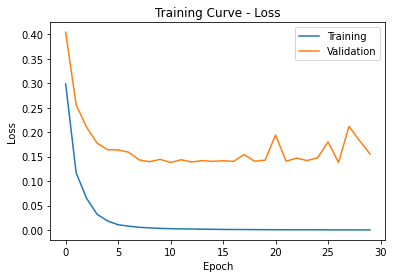

Final Training Loss: 0.00041897296264155386
Final Validation Loss: 0.1553609793772921



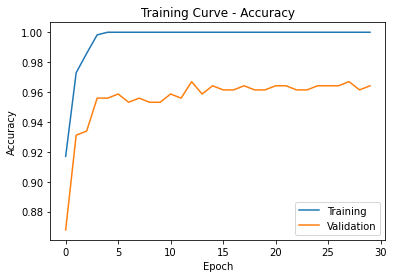

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9641873278236914


In [ ]:
# Load saved feature tensors
train_features = datasets.DatasetFolder(root_folder + "/training", loader = torch.load, extensions = ".pt")
valid_features = datasets.DatasetFolder(root_folder + "/validation", loader = torch.load, extensions = ".pt")
test_features = datasets.DatasetFolder(root_folder + "/test", loader = torch.load, extensions = ".pt")


# Create model and train
modelAN = GestureClassifierAN()
if torch.cuda.is_available:
    modelAN.cuda()

train(modelAN, train_features, valid_features, learning_rate = 0.001, batch_size = 32, num_epochs = 30)


#### Test Accuracy

In [ ]:
test_loader = torch.utils.data.DataLoader(test_features, batch_size = 32, shuffle = True, num_workers = 2)

accuracy = evaluate(modelAN, test_loader)
print(accuracy)


0.9397260273972603


### Testing with Personal Dataset

In [ ]:
# Evaluates the accuracy of given a model (+ runs AlexNet features) and data loader

def evaluate2(model, loader):
    total_correct = 0
    total_examples = 0

    for i, [inputs, labels] in enumerate(loader):
        outputs = model(alexNet.features(inputs))
        
        # Track total correct
        pred = outputs.argmax(dim = 1)
        total_correct += pred.eq(labels).sum().item()
        total_examples += inputs.shape[0]

    return total_correct/total_examples


In [ ]:
alexNet.cpu()       # Use CPU since small sample and simpler code
modelAN.cpu()

my_data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/APS360/Lab 3/My Hand Gestures", transform = transforms.ToTensor())
my_loader = torch.utils.data.DataLoader(my_data)

accuracy = evaluate2(modelAN, my_loader)
print(accuracy)

0.9259259259259259




> The test accuracy on my own dataset is 92.6%. It's still very good, albeit slightly lower than the test accuracy of 94.0% on the given dataset. 

> The given dataset comprised of images of many past students; some may have been incorrectly labelled, and some may have been taken in different orientations and lighting conditions. This enhances the model's ability to generalize to different image conditions. However, the training, validation, and test split were all taken from this single pool. Because each student took 3 images per classification, it's possible that some of these "3 images" (of very similar conditions) were split across the training and test sets. Therefore, the test set is not a true measure of how the model performs against completely unseen inputs.

> Because the model has never seen the conditions of my hand images before, therefore it's expected for the test accuracy to be lower than that of the given dataset.



